In [1]:
# Block 1: Setup + load CTI-HAL
import json
from pathlib import Path

# Mount Drive in Colab if present; no-op locally.
try:
    from google.colab import drive  # type: ignore

    if not Path("/content/drive").exists():
        drive.mount("/content/drive")
except Exception:
    pass

base_dir = Path("CTI-HAL") / "data"
json_files = sorted(base_dir.rglob("*.json"))

rows = []
for path in json_files:
    with path.open("r", encoding="utf-8") as f:
        data = json.load(f)
    if not isinstance(data, list):
        continue
    for item in data:
        metadata = item.get("metadata") or {}
        rows.append(
            {
                "context": item.get("context"),
                "technique": item.get("technique"),
                "tactic": metadata.get("tactic"),
                "tactic_name": metadata.get("tactic_name"),
                "page_number": metadata.get("page_number"),
                "link": metadata.get("link"),
                "tool": metadata.get("tool"),
                "tool_name": metadata.get("tool_name"),
                "source": metadata.get("source"),
                "id": metadata.get("id"),
                "file": str(path).replace("\\", "/"),
            }
        )

print(f"Loaded {len(rows)} rows from {len(json_files)} JSON files")
rows[:3]

Loaded 1701 rows from 81 JSON files


[{'context': 'MiniDuke',
  'technique': None,
  'tactic': [],
  'tactic_name': [],
  'page_number': 2,
  'link': None,
  'tool': ['S0051'],
  'tool_name': ['MINIDUKE'],
  'source': None,
  'id': '000',
  'file': 'CTI-HAL/data/apt29/annotator L/COSMIC.json'},
 {'context': 'CosmicDuke infections start by tricking victims into opening either a PDF file that contains an exploit',
  'technique': 'T1203',
  'tactic': ['TA0002'],
  'tactic_name': ['EXECUTION'],
  'page_number': 2,
  'link': None,
  'tool': ['S0050'],
  'tool_name': ['COSMICDUKE'],
  'source': 'TEXT',
  'id': 'T01',
  'file': 'CTI-HAL/data/apt29/annotator L/COSMIC.json'},
 {'context': 'a Windows executable whose filename is manipulated to make it look like a document or image file.',
  'technique': None,
  'tactic': [],
  'tactic_name': [],
  'page_number': 2,
  'link': ['002', '003'],
  'tool': [],
  'tool_name': [],
  'source': None,
  'id': 'T02',
  'file': 'CTI-HAL/data/apt29/annotator L/COSMIC.json'}]

## Block 2: Normalize into a clean dataframe
Convert the loaded annotations into a compact evidence table with columns: `report_id`, `text`, `technique`, `tactic`, `page`, `link`. Clean the text (strip whitespace), drop empty rows, and deduplicate so each evidence sentence maps cleanly to a technique label for training. Also build a small CTI-HAL example bank for few-shot grounding (used later when the LLM is uncertain).


In [31]:
# Block 2: Normalize into a clean dataframe
import pandas as pd

# Build report_id with sensible fallbacks.
for row in rows:
    if not row.get("id") and row.get("source"):
        row["id"] = row["source"]
    if not row.get("id"):
        row["id"] = Path(row.get("file", "")).stem

df = pd.DataFrame(rows)

df = df.rename(
    columns={
        "context": "text",
        "page_number": "page",
        "id": "report_id",
    }
)[["report_id", "text", "technique", "tactic", "page", "link"]]

# Normalize unhashable values for deduping (lists/dicts -> strings).
def _normalize_cell(value: object) -> str:
    if isinstance(value, list):
        return ", ".join(map(str, value))
    if isinstance(value, dict):
        return json.dumps(value, sort_keys=True)
    if value is None:
        return ""
    return str(value)

for col in ["technique", "tactic", "page", "link"]:
    df[col] = df[col].map(_normalize_cell)

# Clean text and remove empty or duplicate evidence rows.
df["text"] = df["text"].fillna("").astype(str).str.strip()

df = df[df["text"] != ""].drop_duplicates().reset_index(drop=True)

print(f"Clean rows: {len(df)}")

# Build a small few-shot example bank for GenAI grounding.
example_bank = pd.DataFrame(rows).rename(
    columns={
        "context": "text",
        "page_number": "page",
        "id": "report_id",
    }
)[
    [
        "report_id",
        "text",
        "technique",
        "tactic",
        "tool",
        "tool_name",
        "page",
        "link",
    ]
]

for col in ["technique", "tactic", "tool", "tool_name", "page", "link"]:
    example_bank[col] = example_bank[col].map(_normalize_cell)

example_bank["text"] = example_bank["text"].fillna("").astype(str).str.strip()

example_bank = example_bank[
    (example_bank["text"] != "")
    & (example_bank["technique"].str.lower() != "nan")
    & (example_bank["technique"] != "")
].drop_duplicates()

EXAMPLE_BANK_SIZE = 300
if len(example_bank) > EXAMPLE_BANK_SIZE:
    example_bank = example_bank.sample(n=EXAMPLE_BANK_SIZE, random_state=42)

example_bank = example_bank.reset_index(drop=True)

print(f"Example bank size: {len(example_bank)}")
example_bank.head()

Clean rows: 1694
Example bank size: 300


,report_id,text,technique,tactic,tool,tool_name,page,link
0,004,obfuscated JavaScript,T1027,TA0005,,,4.0,003
1,012,Impersonation using Kerberos pass-the-ticket a...,T1558,TA0006,S0002,Mimikatz,5.0,
2,009,SandWorm leveraged customized malware to overw...,T1552,TA0006,,,7.0,
3,010,it will determine on which operating system it...,T1082,None,,,6.0,
4,035,A 256-bit AES session key is generated and use...,T1573,TA0011,S0030,CARBANAK,8.0,036


## Block 3: RAG step for graph context detection (retrieve then extract)
For each new telemetry chunk, retrieve top‑k similar CTI‑HAL contexts by embedding similarity. Then pass the telemetry text + retrieved examples + a local subgraph snapshot to the LLM and ask it to output only a JSON graph‑context object. This grounds extraction in known technique‑context patterns.


In [33]:
# Block 3: RAG step for graph context detection (retrieve then extract)
import numpy as np

# Build embeddings for the CTI-HAL example bank.
try:
    from sentence_transformers import SentenceTransformer
except ImportError as exc:
    raise ImportError(
        "Install sentence-transformers to run this block: pip install sentence-transformers"
    ) from exc

embedder = SentenceTransformer("all-MiniLM-L6-v2")
example_texts = example_bank["text"].tolist()
example_emb = embedder.encode(example_texts, show_progress_bar=True, normalize_embeddings=True)

# Optional FAISS index for faster retrieval.
faiss_index = None
try:
    import faiss  # type: ignore

    dim = example_emb.shape[1]
    faiss_index = faiss.IndexFlatIP(dim)
    faiss_index.add(example_emb.astype("float32"))
except Exception:
    faiss_index = None


def retrieve_examples(query: str, k: int = 5) -> pd.DataFrame:
    query_emb = embedder.encode([query], normalize_embeddings=True).astype("float32")

    if faiss_index is not None:
        scores, indices = faiss_index.search(query_emb, k)
        top_idx = indices[0]
        top_scores = scores[0]
    else:
        scores = (example_emb @ query_emb.T).ravel()
        top_idx = np.argsort(scores)[-k:][::-1]
        top_scores = scores[top_idx]

    return example_bank.iloc[top_idx].assign(similarity=top_scores)


def local_subgraph_snapshot(techniques: list[str], top_k: int = 10) -> list[dict]:
    if "transition_df" not in globals():
        return []
    mask = transition_df["source"].isin(techniques) | transition_df["target"].isin(techniques)
    snap = transition_df[mask].head(top_k)
    return snap.to_dict(orient="records")


def build_graph_context_prompt(telemetry: str, examples: pd.DataFrame, subgraph: list[dict]) -> str:
    ex_lines = []
    for _, row in examples.iterrows():
        ex_lines.append(
            f"TEXT: {row['text']}\n"
            f"TECHNIQUE: {row['technique']}\n"
            f"TACTIC: {row['tactic']}\n"
            f"TOOL: {row.get('tool', '')}\n"
            f"PAGE: {row.get('page', '')}\n"
            f"LINK: {row.get('link', '')}\n"
        )
    ex_block = "\n---\n".join(ex_lines)

    return (
        "You are an extraction model. Given telemetry and a few labeled examples, "
        "output only a JSON object with fields: techniques (list), tactics (list), "
        "tools (list), evidence (list of strings), confidence (0-1).\n\n"
        f"Telemetry:\n{telemetry}\n\n"
        f"Retrieved examples:\n{ex_block}\n\n"
        f"Local subgraph snapshot:\n{subgraph}\n\n"
        "Return ONLY valid JSON."
    )


def run_rag_extraction(telemetry: str, k: int = 5) -> str:
    examples = retrieve_examples(telemetry, k=k)
    # Use retrieved techniques to seed a local snapshot.
    seed_tech = [t for t in examples["technique"].tolist() if t]
    subgraph = local_subgraph_snapshot(seed_tech, top_k=10)
    prompt = build_graph_context_prompt(telemetry, examples, subgraph)

    if not OPENAI_API_KEY:
        return "OPENAI_API_KEY not set; skipping GenAI call."

    try:
        from openai import OpenAI

        client = OpenAI(api_key=OPENAI_API_KEY)
        response = client.responses.create(
            model="gpt-4.1-mini",
            input=prompt,
        )
        return response.output_text.strip()
    except Exception as exc:
        return f"GenAI call failed: {exc}"


# Example telemetry
telemetry_sample = "PowerShell ran an encoded command that downloaded a payload over HTTPS."
retrieved = retrieve_examples(telemetry_sample, k=5)
print(retrieved[["technique", "tactic", "tool", "page", "link", "similarity"]].head())

print("\nRAG extraction output:")
print(run_rag_extraction(telemetry_sample, k=5))

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1052.80it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 10/10 [00:00<00:00, 10.15it/s]


    technique  tactic tool  page link  similarity
108     T1027  TA0005        2.0  005    0.593456
251     T1027  TA0005        1.0  012    0.550514
244     T1071  TA0011       32.0         0.506035
179     T1027  TA0005       14.0         0.496319
162     T1027  TA0005        5.0         0.490826

RAG extraction output:
```json
{
  "techniques": ["T1027", "T1071"],
  "tactics": ["TA0005", "TA0011"],
  "tools": [],
  "evidence": [
    "PowerShell ran an encoded command",
    "downloaded a payload over HTTPS",
    "PowerShell commands with base64 encoding",
    "An HTTP protocol with encrypted payload is used for the Command & Control communication."
  ],
  "confidence": 0.9
}
```


In [34]:
# Block 4: Guardrails for LLM output
import json as _json
import re
from typing import List

from pydantic import BaseModel, Field, ValidationError, field_validator


class GraphContext(BaseModel):
    techniques: List[str] = Field(default_factory=list)
    tactics: List[str] = Field(default_factory=list)
    tools: List[str] = Field(default_factory=list)
    evidence: List[str] = Field(default_factory=list)
    confidence: float

    @field_validator("confidence")
    @classmethod
    def _conf_range(cls, v: float) -> float:
        if not 0.0 <= v <= 1.0:
            raise ValueError("confidence must be between 0 and 1")
        return v


# Simple deterministic fallback using keyword/regex matches.
RULES = [
    (re.compile(r"powershell|pwsh", re.I), "T1059"),
    (re.compile(r"encoded command|base64", re.I), "T1027"),
    (re.compile(r"download|http|https|curl|wget", re.I), "T1105"),
    (re.compile(r"credential dumping|lsass", re.I), "T1003"),
    (re.compile(r"phish|spearphish|email attachment", re.I), "T1566"),
]


def conservative_extract(text: str) -> GraphContext:
    techniques = []
    evidence = []
    for pattern, tech in RULES:
        if pattern.search(text):
            techniques.append(tech)
            evidence.append(pattern.pattern)

    tactics = [technique_to_tactic.get(t, "") for t in techniques]
    tactics = [t for t in tactics if t]
    return GraphContext(
        techniques=sorted(set(techniques)),
        tactics=sorted(set(tactics)),
        tools=[],
        evidence=evidence,
        confidence=0.4 if techniques else 0.2,
    )


def _parse_llm_json(raw: str) -> GraphContext:
    data = _json.loads(raw)
    return GraphContext(**data)


def _fix_json_prompt(raw: str) -> str:
    return (
        "Fix the JSON to match this schema exactly and return ONLY valid JSON:\n"
        "{techniques: [string], tactics: [string], tools: [string], "
        "evidence: [string], confidence: number between 0 and 1}.\n\n"
        f"RAW:\n{raw}"
    )


def run_rag_with_guardrails(telemetry: str, k: int = 5, min_conf: float = 0.3) -> GraphContext:
    examples = retrieve_examples(telemetry, k=k)
    seed_tech = [t for t in examples["technique"].tolist() if t]
    subgraph = local_subgraph_snapshot(seed_tech, top_k=10)
    prompt = build_graph_context_prompt(telemetry, examples, subgraph)

    if not OPENAI_API_KEY:
        return conservative_extract(telemetry)

    try:
        from openai import OpenAI

        client = OpenAI(api_key=OPENAI_API_KEY)
        raw = client.responses.create(model="gpt-4.1-mini", input=prompt).output_text.strip()
        try:
            parsed = _parse_llm_json(raw)
            if parsed.confidence >= min_conf:
                return parsed
        except Exception:
            pass

        # Retry once with fix JSON only prompt.
        fix_prompt = _fix_json_prompt(raw)
        fixed = client.responses.create(model="gpt-4.1-mini", input=fix_prompt).output_text.strip()
        parsed = _parse_llm_json(fixed)
        if parsed.confidence < min_conf:
            return conservative_extract(telemetry)
        return parsed
    except Exception:
        return conservative_extract(telemetry)


# Example guardrailed extraction
telemetry_sample = "PowerShell ran an encoded command that downloaded a payload over HTTPS."
print(run_rag_with_guardrails(telemetry_sample, k=5).model_dump())

{'techniques': ['T1027', 'T1059', 'T1105'], 'tactics': ['TA0002', 'TA0005', 'TA0011'], 'tools': [], 'evidence': ['powershell|pwsh', 'encoded command|base64', 'download|http|https|curl|wget'], 'confidence': 0.4}


## Block 5: Graph update operator (write once, reuse everywhere)
Apply a single update function that merges entities, adds/updates technique nodes, adds timestamped edges, and updates confidence using a simple EMA rule. Treat GenAI output as deltas, not absolute truth.


In [35]:
# Block 5: Graph update operator (write once, reuse everywhere)
from datetime import datetime


def _norm_key(value: str) -> str:
    return re.sub(r"\s+", " ", str(value).strip().lower())


def _ema(prev: float, new: float, alpha: float = 0.6) -> float:
    if prev is None:
        return new
    return alpha * new + (1 - alpha) * prev


def apply_graph_context(ctx_json: dict, graph: "nx.DiGraph") -> "nx.DiGraph":
    # Treat ctx_json as deltas; merge into graph with simple normalization.
    techniques = ctx_json.get("techniques", [])
    tactics = ctx_json.get("tactics", [])
    tools = ctx_json.get("tools", [])
    evidence = ctx_json.get("evidence", [])
    confidence = float(ctx_json.get("confidence", 0.5))

    timestamp = datetime.utcnow().isoformat(timespec="seconds") + "Z"

    # Add or update technique nodes.
    for tech in techniques:
        key = _norm_key(tech)
        node_id = f"tech:{key}"
        if node_id not in graph:
            graph.add_node(
                node_id,
                label=tech,
                kind="technique",
                confidence=confidence,
                first_seen=timestamp,
            )
        else:
            prev = graph.nodes[node_id].get("confidence")
            graph.nodes[node_id]["confidence"] = _ema(prev, confidence)
            graph.nodes[node_id]["last_seen"] = timestamp

    # Add or update tactic nodes.
    for tactic in tactics:
        key = _norm_key(tactic)
        node_id = f"tactic:{key}"
        if node_id not in graph:
            graph.add_node(
                node_id,
                label=tactic,
                kind="tactic",
                confidence=confidence,
                first_seen=timestamp,
            )
        else:
            prev = graph.nodes[node_id].get("confidence")
            graph.nodes[node_id]["confidence"] = _ema(prev, confidence)
            graph.nodes[node_id]["last_seen"] = timestamp

    # Add or update tool nodes.
    for tool in tools:
        key = _norm_key(tool)
        node_id = f"tool:{key}"
        if node_id not in graph:
            graph.add_node(
                node_id,
                label=tool,
                kind="tool",
                confidence=confidence,
                first_seen=timestamp,
            )
        else:
            prev = graph.nodes[node_id].get("confidence")
            graph.nodes[node_id]["confidence"] = _ema(prev, confidence)
            graph.nodes[node_id]["last_seen"] = timestamp

    # Add edges between techniques and tactics/tools.
    for tech in techniques:
        tech_id = f"tech:{_norm_key(tech)}"
        for tactic in tactics:
            tactic_id = f"tactic:{_norm_key(tactic)}"
            _upsert_edge(graph, tech_id, tactic_id, confidence, evidence, timestamp)
        for tool in tools:
            tool_id = f"tool:{_norm_key(tool)}"
            _upsert_edge(graph, tech_id, tool_id, confidence, evidence, timestamp)

    return graph


def _upsert_edge(
    graph: "nx.DiGraph",
    source: str,
    target: str,
    confidence: float,
    evidence: list[str],
    timestamp: str,
) -> None:
    if not graph.has_edge(source, target):
        graph.add_edge(
            source,
            target,
            confidence=confidence,
            evidence=list(evidence),
            first_seen=timestamp,
            last_seen=timestamp,
        )
    else:
        prev = graph.edges[source, target].get("confidence")
        graph.edges[source, target]["confidence"] = _ema(prev, confidence)
        graph.edges[source, target]["last_seen"] = timestamp
        if evidence:
            graph.edges[source, target].setdefault("evidence", []).extend(evidence)


# Example update
graph = nx.DiGraph()
example_ctx = run_rag_with_guardrails(
    "PowerShell ran an encoded command that downloaded a payload over HTTPS.",
    k=5,
).model_dump()

apply_graph_context(example_ctx, graph)
print("Nodes:", graph.number_of_nodes(), "Edges:", graph.number_of_edges())

Nodes: 6 Edges: 9


C:\Users\sayan\AppData\Local\Temp\ipykernel_27980\3243861936.py:23: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().isoformat(timespec="seconds") + "Z"


## Block 6: Context windowing (active subgraph)
Maintain a sliding time window (e.g., last 60 minutes) and compute an active subgraph. Repeated detections in the window raise node/edge confidence, giving a coherent attack narrative instead of isolated detections.


In [36]:
# Block 6: Context windowing (active subgraph)
from datetime import datetime, timedelta, timezone

# Keep a rolling log of detections.
detection_log: list[dict] = []


def log_detection(ctx: dict) -> None:
    detection_log.append(
        {
            "timestamp": datetime.now(timezone.utc),
            "techniques": ctx.get("techniques", []),
            "tactics": ctx.get("tactics", []),
            "tools": ctx.get("tools", []),
            "confidence": float(ctx.get("confidence", 0.5)),
        }
    )


def active_subgraph(window_minutes: int = 60) -> dict:
    cutoff = datetime.now(timezone.utc) - timedelta(minutes=window_minutes)
    recent = [d for d in detection_log if d["timestamp"] >= cutoff]

    # Aggregate confidence by technique within the window.
    tech_scores: dict[str, float] = {}
    for d in recent:
        for tech in d["techniques"]:
            tech_scores[tech] = tech_scores.get(tech, 0.0) + d["confidence"]

    # Normalize to 0..1 range by count (simple heuristic).
    for tech in tech_scores:
        count = sum(tech in d["techniques"] for d in recent)
        tech_scores[tech] = tech_scores[tech] / max(1, count)

    # Build an active edge list from the global transition graph.
    if "transition_df" in globals():
        active_edges = transition_df[
            transition_df["source"].isin(tech_scores.keys())
            | transition_df["target"].isin(tech_scores.keys())
        ].copy()
        active_edges = active_edges.head(20)
    else:
        active_edges = pd.DataFrame(columns=["source", "target", "weight"])

    return {
        "window_minutes": window_minutes,
        "technique_scores": tech_scores,
        "active_edges": active_edges,
        "count": len(recent),
    }


# Example: log a few detections and compute the active subgraph.
example_ctx = run_rag_with_guardrails(
    "PowerShell ran an encoded command that downloaded a payload over HTTPS.",
    k=5,
).model_dump()
log_detection(example_ctx)

active = active_subgraph(window_minutes=60)
print("Detections in window:", active["count"])
print("Top techniques:", sorted(active["technique_scores"].items(), key=lambda x: x[1], reverse=True)[:5])
active["active_edges"].head()

Detections in window: 1
Top techniques: [('T1027', 0.4), ('T1059', 0.4), ('T1105', 0.4)]


,source,target,weight
0,T1027,T1059,23
1,T1566,T1059,18
2,T1059,T1105,17
3,T1059,T1566,16
4,T1059,T1027,13


### Block 6b: Visualize active subgraph
Quick visualization of the current active subgraph edges to show the evolving narrative.


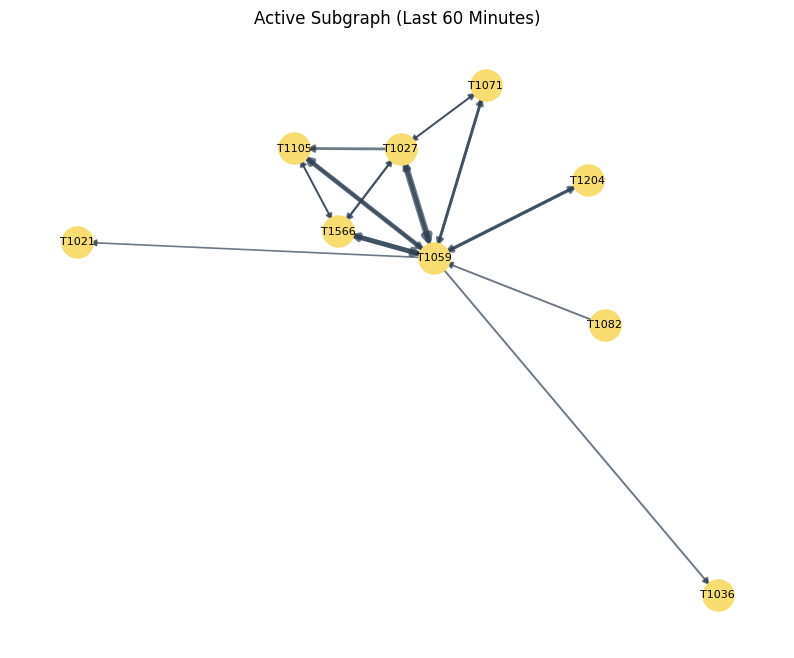

In [37]:
# Block 6b: Visualize active subgraph
import networkx as nx
import matplotlib.pyplot as plt

active = active_subgraph(window_minutes=60)
active_edges = active["active_edges"]

if len(active_edges) == 0:
    print("No active edges in window.")
else:
    G_active = nx.DiGraph()
    for _, row in active_edges.iterrows():
        G_active.add_edge(row["source"], row["target"], weight=int(row["weight"]))

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G_active, seed=42, k=0.8)
    weights = [G_active[u][v]["weight"] for u, v in G_active.edges()]
    widths = [max(1.0, w / 5.0) for w in weights]

    nx.draw_networkx_nodes(G_active, pos, node_size=500, node_color="#f7dc6f")
    nx.draw_networkx_edges(G_active, pos, arrows=True, width=widths, alpha=0.7, edge_color="#2e4053")
    nx.draw_networkx_labels(G_active, pos, font_size=8)

    plt.title("Active Subgraph (Last 60 Minutes)")
    plt.axis("off")
    plt.show()

## Block 7: GenAI-driven graph context classification
Given the active subgraph summary, known techniques, and tactic hints, ask the LLM for a likely attack stage, missing techniques (from known set only), and evidence to confirm/refute.


In [ ]:
# Block 7: GenAI-driven graph context classification
from typing import Any
import re


def summarize_active_subgraph(active: dict, top_k: int = 10) -> dict:
    tech_scores = active.get("technique_scores", {})
    top_techs = sorted(tech_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
    edges = active.get("active_edges")
    edge_list = []
    if hasattr(edges, "iterrows"):
        for _, row in edges.head(top_k).iterrows():
            edge_list.append({"source": row["source"], "target": row["target"], "weight": int(row["weight"])})
    return {"top_techniques": top_techs, "edges": edge_list}


def build_stage_prompt(active_summary: dict, tactic_hints: list[str], known_techniques: list[str]) -> str:
    return (
        "You are a cyber analyst. Given an active subgraph summary and tactic hints, "
        "return ONLY valid JSON with keys: stage, missing_techniques, evidence_to_confirm, evidence_to_refute. "
        "The missing_techniques MUST be drawn from the provided known_techniques list only.\n\n"
        f"Active subgraph summary:\n{active_summary}\n\n"
        f"Tactic hints:\n{tactic_hints}\n\n"
        f"Known techniques:\n{known_techniques}\n\n"
        "Return ONLY JSON."
    )


def _fix_stage_json_prompt(raw: str) -> str:
    return (
        "Fix the JSON to match this schema exactly and return ONLY valid JSON:\n"
        "{stage: string, missing_techniques: [string], evidence_to_confirm: [string], "
        "evidence_to_refute: [string]}.\n\n"
        f"RAW:\n{raw}"
    )


def _extract_json_object(text: str) -> str:
    match = re.search(r"\{.*\}", text, re.DOTALL)
    if not match:
        raise ValueError("No JSON object found in response.")
    return match.group(0)


def run_stage_classification(active: dict, max_attempts: int = 3) -> dict[str, Any]:
    active_summary = summarize_active_subgraph(active)
    tactic_hints = [technique_to_tactic.get(t, "") for t, _ in active_summary["top_techniques"]]
    tactic_hints = [t for t in tactic_hints if t]

    # Constrain to known techniques from the example bank / embeddings.
    if "mlb" in globals():
        known_techniques = list(mlb.classes_)
    else:
        known_techniques = sorted(set(example_bank["technique"]))

    prompt = build_stage_prompt(active_summary, tactic_hints, known_techniques)

    if not OPENAI_API_KEY:
        return {
            "stage": "",
            "missing_techniques": [],
            "evidence_to_confirm": [],
            "evidence_to_refute": [],
        }

    try:
        from openai import OpenAI

        client = OpenAI(api_key=OPENAI_API_KEY)
        last_error: Exception | None = None

        for attempt in range(1, max_attempts + 1):
            raw = client.responses.create(model="gpt-4.1-mini", input=prompt).output_text
            raw = (raw or "").strip()
            if not raw:
                last_error = ValueError("Empty response from model.")
                continue

            try:
                return _json.loads(raw)
            except Exception:
                try:
                    cleaned = _extract_json_object(raw)
                    return _json.loads(cleaned)
                except Exception:
                    fix_prompt = _fix_stage_json_prompt(raw)
                    fixed = client.responses.create(model="gpt-4.1-mini", input=fix_prompt).output_text
                    fixed = (fixed or "").strip()
                    if not fixed:
                        last_error = ValueError("Empty response from JSON-fix step.")
                        continue
                    try:
                        return _json.loads(fixed)
                    except Exception:
                        try:
                            cleaned = _extract_json_object(fixed)
                            return _json.loads(cleaned)
                        except Exception as exc:
                            last_error = exc
                            continue

        raise last_error or ValueError("Stage classification failed after retries.")
    except Exception as exc:
        return {
            "stage": "",
            "missing_techniques": [],
            "evidence_to_confirm": [f"GenAI call failed: {exc}"],
            "evidence_to_refute": [],
        }


# Example classification using current active subgraph.
active = active_subgraph(window_minutes=60)
result = run_stage_classification(active)
print(result)

{'stage': 'Execution', 'missing_techniques': ['T1566', 'T1204', 'T1071'], 'evidence_to_confirm': ['Edges from T1566 to T1059 and T1059 to T1566 indicate possible use of phishing (T1566).', 'Edges between T1204 and T1059 suggest user execution techniques (T1204).', 'Edge from T1071 to T1059 implies possible command and control over application layer protocol (T1071).'], 'evidence_to_refute': []}


## Block 8: Close the CAIRN-style loop (infer -> intervene -> observe)
Use the Bayesian or transition model to rank likely next techniques, then let GenAI translate those into concrete checks (log source, query, endpoint artifact). The probabilistic model does scoring; GenAI does the actionable mapping.


In [46]:
# Block 8: Close the CAIRN-style loop (infer -> intervene -> observe)
import json as _json


def rank_next_techniques(active: dict, top_n: int = 5) -> list[dict]:
    observed = {t for t, _ in summarize_active_subgraph(active).get("top_techniques", [])}

    if not observed and detection_log:
        observed = set(detection_log[-1].get("techniques", []))

    if "model" in globals() and "infer_missing" in globals() and observed:
        scored = infer_missing(observed, model, top_n=top_n)
        return [{"technique": t, "score": float(s)} for t, s in scored]

    if "transition_df" in globals() and observed:
        outgoing = transition_df[transition_df["source"].isin(observed)]
        scores = outgoing.groupby("target")["weight"].sum().sort_values(ascending=False).head(top_n)
        return [{"technique": t, "score": float(s)} for t, s in scores.items()]

    return []


def _extract_json_object(text: str) -> str:
    match = re.search(r"\[.*\]", text, re.DOTALL)
    if not match:
        match = re.search(r"\{.*\}", text, re.DOTALL)
    if not match:
        raise ValueError("No JSON object found in response.")
    return match.group(0)


def build_intervention_prompt(candidates: list[dict], context: dict) -> str:
    return (
        "You are a SOC analyst. Convert ranked techniques into concrete checks. "
        "Return ONLY valid JSON array with objects: technique, score, log_source, query, "
        "endpoint_artifact, rationale.\n\n"
        f"Ranked techniques: {candidates}\n\n"
        f"Context summary: {context}\n\n"
        "Return ONLY JSON array."
    )


def genai_intervention_suggestions(candidates: list[dict], context: dict) -> list[dict]:
    if not candidates:
        return []
    if not OPENAI_API_KEY:
        return []

    try:
        from openai import OpenAI

        client = OpenAI(api_key=OPENAI_API_KEY)
        prompt = build_intervention_prompt(candidates, context)
        raw = client.responses.create(model="gpt-4.1-mini", input=prompt).output_text
        raw = (raw or "").strip()
        if not raw:
            raise ValueError("Empty response from model.")
        try:
            data = _json.loads(raw)
        except Exception:
            data = _json.loads(_extract_json_object(raw))
        if isinstance(data, dict):
            return [data]
        return data
    except Exception:
        return []


def fallback_interventions(candidates: list[dict]) -> list[dict]:
    playbook = {
        "T1059": {"log_source": "PowerShell Operational", "query": "EventID=4104", "endpoint_artifact": "ScriptBlockText"},
        "T1027": {"log_source": "EDR Process", "query": "command_line contains 'base64'", "endpoint_artifact": "encoded_payload"},
        "T1105": {"log_source": "Proxy/Netflow", "query": "outbound http(s) with rare user-agent", "endpoint_artifact": "downloaded_file"},
        "T1566": {"log_source": "Email Gateway", "query": "suspicious attachment or link", "endpoint_artifact": "message_id"},
        "T1204": {"log_source": "EDR Process", "query": "user double-clicked from Downloads", "endpoint_artifact": "parent_process"},
        "T1071": {"log_source": "Proxy/DNS", "query": "beaconing to low-reputation domain", "endpoint_artifact": "domain"},
    }

    results = []
    for item in candidates:
        tech = item["technique"]
        base = playbook.get(tech, {"log_source": "EDR/Network", "query": "suspicious activity", "endpoint_artifact": "host"})
        results.append(
            {
                "technique": tech,
                "score": float(item.get("score", 0.0)),
                "log_source": base["log_source"],
                "query": base["query"],
                "endpoint_artifact": base["endpoint_artifact"],
                "rationale": "Fallback mapping; confirm with telemetry.",
            }
        )
    return results


# Example: rank next techniques and generate intervention suggestions.
active = active_subgraph(window_minutes=60)
ranked = rank_next_techniques(active, top_n=5)
print("Ranked next techniques:", ranked)

context_summary = summarize_active_subgraph(active)
recommendations = genai_intervention_suggestions(ranked, context_summary)
if not recommendations:
    recommendations = fallback_interventions(ranked)

print("Intervention suggestions:")
for rec in recommendations:
    print(rec)


Ranked next techniques: [{'technique': 'T1071', 'score': 0.8461538461538461}, {'technique': 'T1082', 'score': 0.41333333333333333}, {'technique': 'T1003', 'score': 0.37333333333333335}, {'technique': 'T1036', 'score': 0.37333333333333335}, {'technique': 'T1204', 'score': 0.37333333333333335}]
Intervention suggestions:
{'technique': 'T1071', 'score': 0.8461538461538461, 'log_source': 'network_traffic', 'query': "SELECT * FROM network_traffic WHERE destination_port IN (80, 443, 8080) AND protocol IN ('HTTP', 'HTTPS') AND (user_agent LIKE '%curl%' OR user_agent LIKE '%wget%' OR user_agent LIKE '%powershell%')", 'endpoint_artifact': 'network_connections.log', 'rationale': 'Detects command and control or data exfiltration activity over common application layer protocols by monitoring unusual HTTP/S user agents or non-browser traffic.'}
{'technique': 'T1082', 'score': 0.41333333333333333, 'log_source': 'process_creation', 'query': "SELECT * FROM process_creation WHERE parent_process_name IN 

## Block 9: Self-improving loop (active learning, not magical thinking)
Log low-confidence or corrected cases into a hard-examples table. Periodically add them to the retrieval bank, optionally fine-tune the lightweight classifier, and update transition counts to keep the system improving with minimal manual effort.


In [ ]:
# Block 9: Self-improving loop (active learning, not magical thinking)
from datetime import datetime, timezone


# Store hard examples for active learning and retrieval refresh.
hard_examples: list[dict] = []


def log_hard_example(
    text: str,
    predicted: dict,
    corrected: dict | None = None,
    reason: str = "low_confidence",
) -> None:
    hard_examples.append(
        {
            "timestamp": datetime.now(timezone.utc).isoformat(),
            "text": text,
            "predicted": predicted,
            "corrected": corrected or {},
            "reason": reason,
        }
    )


def maybe_log_low_confidence(text: str, ctx: dict, threshold: float = 0.4) -> None:
    conf = float(ctx.get("confidence", 0.0))
    if conf < threshold:
        log_hard_example(text, ctx, reason=f"confidence<{threshold}")


def refresh_example_bank(new_examples: list[dict], max_new: int = 200) -> None:
    global example_bank, example_emb, faiss_index

    if not new_examples:
        return

    new_df = pd.DataFrame(new_examples)
    if "technique" not in new_df.columns:
        return

    cols = ["text", "technique", "tactic", "tool", "tool_name", "page", "link", "report_id"]
    for col in cols:
        if col not in new_df.columns:
            new_df[col] = ""

    new_df["text"] = new_df["text"].fillna("").astype(str).str.strip()
    new_df = new_df[(new_df["text"] != "") & (new_df["technique"] != "")]

    if len(new_df) > max_new:
        new_df = new_df.sample(n=max_new, random_state=42)

    example_bank = pd.concat([example_bank, new_df], ignore_index=True).drop_duplicates()

    # Rebuild embeddings and FAISS index with the augmented bank.
    example_texts = example_bank["text"].tolist()
    example_emb = embedder.encode(example_texts, show_progress_bar=True, normalize_embeddings=True)

    faiss_index = None
    try:
        import faiss  # type: ignore

        dim = example_emb.shape[1]
        faiss_index = faiss.IndexFlatIP(dim)
        faiss_index.add(example_emb.astype("float32"))
    except Exception:
        faiss_index = None


def update_transition_counts(new_examples: list[dict]) -> None:
    global transition_df
    if not new_examples:
        return

    new_df = pd.DataFrame(new_examples)
    if "report_id" not in new_df.columns:
        new_df["report_id"] = "hard_example"

    new_df = new_df.rename(columns={"technique": "technique_norm"})
    new_df["technique_norm"] = new_df["technique_norm"].fillna("").astype(str).str.strip()
    new_df = new_df[new_df["technique_norm"] != ""]

    edge_counts = Counter()
    for report_id, group in new_df.groupby("report_id"):
        techniques = group["technique_norm"].tolist()
        for a, b in zip(techniques, techniques[1:]):
            if a == b:
                continue
            edge_counts[(a, b)] += 1

    if edge_counts:
        add_df = pd.DataFrame(
            [(a, b, w) for (a, b), w in edge_counts.items()],
            columns=["source", "target", "weight"],
        )
        transition_df = (
            pd.concat([transition_df, add_df], ignore_index=True)
            .groupby(["source", "target"], as_index=False)["weight"]
            .sum()
            .sort_values("weight", ascending=False)
            .reset_index(drop=True)
        )


def fine_tune_baseline_if_ready(min_examples: int = 50) -> None:
    global baseline_clf, mlb

    if len(hard_examples) < min_examples:
        print(f"Not enough hard examples yet: {len(hard_examples)}/{min_examples}")
        return

    # Build a small training set from corrected labels when available.
    rows = []
    for item in hard_examples:
        corrected = item.get("corrected") or {}
        techniques = corrected.get("techniques") or []
        if not techniques:
            continue
        rows.append({"text": item.get("text", ""), "techniques": techniques})

    if not rows:
        print("No corrected labels to retrain on.")
        return

    train_df = pd.DataFrame(rows)
    train_df = train_df[train_df["text"].str.strip() != ""]

    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(train_df["techniques"])

    baseline_clf = Pipeline(
        [
            ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
            ("clf", OneVsRestClassifier(LogisticRegression(max_iter=2000, n_jobs=-1))),
        ]
    )
    baseline_clf.fit(train_df["text"], y)
    print(f"Baseline fine-tuned on {len(train_df)} hard examples.")


# Example: log and refresh.
example_ctx = run_rag_with_guardrails(
    "PowerShell ran an encoded command that downloaded a payload over HTTPS.",
    k=5,
).model_dump()
maybe_log_low_confidence("PowerShell ran an encoded command that downloaded a payload over HTTPS.", example_ctx)

# Periodic maintenance step.
if hard_examples:
    # Use corrected labels if available, otherwise fall back to predicted techniques.
    refresh_payload = []
    for item in hard_examples:
        corrected = item.get("corrected") or {}
        techniques = corrected.get("techniques") or item.get("predicted", {}).get("techniques", [])
        if not techniques:
            continue
        refresh_payload.append(
            {
                "text": item.get("text", ""),
                "technique": ", ".join(techniques) if isinstance(techniques, list) else str(techniques),
                "tactic": "",
                "tool": "",
                "tool_name": "",
                "page": "",
                "link": "",
                "report_id": "hard_example",
            }
        )

    refresh_example_bank(refresh_payload)
    update_transition_counts(refresh_payload)
    fine_tune_baseline_if_ready(min_examples=50)


## Block 4: Guardrails for LLM output
Validate LLM JSON with a strict Pydantic schema. If validation fails or confidence is too low, retry once with a "fix JSON only" prompt, then fall back to deterministic keyword/regex rules.


### Block 3b: Sentence-embedding baseline (optional)
Swap TF-IDF for sentence embeddings to capture semantics better. This model still outputs per-technique probabilities, but usually improves recall on paraphrased evidence.


In [4]:
# Block 3b: Sentence-embedding baseline (optional)
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

try:
    from sentence_transformers import SentenceTransformer
except ImportError as exc:
    raise ImportError(
        "Install sentence-transformers to run this block: pip install sentence-transformers"
    ) from exc

# Encode text with a compact, strong baseline model.
embedder = SentenceTransformer("all-MiniLM-L6-v2")
X_train_emb = embedder.encode(X_train.tolist(), show_progress_bar=True)
X_test_emb = embedder.encode(X_test.tolist(), show_progress_bar=True)

emb_clf = OneVsRestClassifier(LogisticRegression(max_iter=2000, n_jobs=-1))
emb_clf.fit(X_train_emb, y_train)

emb_proba = emb_clf.predict_proba(X_test_emb)

print("Embedding probabilities shape:", emb_proba.shape)

# Example: top-5 techniques for the first test sample.
first_emb_scores = list(zip(mlb.classes_, emb_proba[0]))
first_emb_scores = sorted(first_emb_scores, key=lambda x: x[1], reverse=True)[:5]
first_emb_scores

e:\Knowledge Graph\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
e:\Knowledge Graph\venv\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sayan\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer m

Embedding probabilities shape: (339, 117)


e:\Knowledge Graph\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
e:\Knowledge Graph\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
e:\Knowledge Graph\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
e:\Knowledge Graph\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warning

[('T1059', np.float64(0.7525277553033096)),
 ('T1105', np.float64(0.06839211402518514)),
 ('T1027', np.float64(0.032489656400739544)),
 ('T1543', np.float64(0.025388694633029035)),
 ('T1204', np.float64(0.025237676370292943))]

In [7]:
# Block 3c: Quick comparison (TF-IDF vs embeddings)
from sklearn.metrics import f1_score
import numpy as np

# Use a simple threshold to compare models.
threshold = 0.5

baseline_pred = (proba >= threshold).astype(int)
baseline_f1 = f1_score(y_test, baseline_pred, average="macro", zero_division=0)

print(f"TF-IDF macro F1 @ {threshold}: {baseline_f1:.3f}")

if "emb_proba" in globals():
    emb_pred = (emb_proba >= threshold).astype(int)
    emb_f1 = f1_score(y_test, emb_pred, average="macro", zero_division=0)
    print(f"Embeddings macro F1 @ {threshold}: {emb_f1:.3f}")
else:
    print("Embeddings not run yet; run Block 3b to compare.")

TF-IDF macro F1 @ 0.5: 0.008
Embeddings macro F1 @ 0.5: 0.021


### Block 3e: Top-k evaluation
Compute precision@k and recall@k to reflect how the model might be used in practice: surfacing a small set of likely techniques per evidence sentence.


In [12]:
# Block 3e: Top-k evaluation
import numpy as np

ks = [1, 3, 5]

def topk_metrics(scores: np.ndarray, y_true: np.ndarray, k: int) -> tuple[float, float]:
    topk = np.argsort(scores, axis=1)[:, -k:]
    precisions = []
    recalls = []
    for i, idxs in enumerate(topk):
        true_idxs = np.where(y_true[i] == 1)[0]
        if len(true_idxs) == 0:
            continue
        hit = len(set(idxs).intersection(set(true_idxs)))
        precisions.append(hit / k)
        recalls.append(hit / len(true_idxs))
    if not precisions:
        return 0.0, 0.0
    return float(np.mean(precisions)), float(np.mean(recalls))

for model_name, scores in [("TF-IDF", proba), ("Embeddings", globals().get("emb_proba"))]:
    if scores is None:
        print(f"{model_name}: skip (not run)")
        continue
    print(f"{model_name} top-k metrics")
    for k in ks:
        p_at_k, r_at_k = topk_metrics(scores, y_test, k)
        print(f"  k={k}: precision@k={p_at_k:.3f}, recall@k={r_at_k:.3f}")

TF-IDF top-k metrics
  k=1: precision@k=0.383, recall@k=0.383
  k=3: precision@k=0.195, recall@k=0.584
  k=5: precision@k=0.129, recall@k=0.646
Embeddings top-k metrics
  k=1: precision@k=0.469, recall@k=0.469
  k=3: precision@k=0.223, recall@k=0.670
  k=5: precision@k=0.145, recall@k=0.726


### Block 3d: Threshold tuning (global)
Sweep a few thresholds and pick the best macro F1 for each model. This gives a quick sense of how sensitive the results are to the decision cutoff.


In [15]:
# Block 3d: Threshold tuning (global)
from sklearn.metrics import f1_score

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]

for model_name, scores in [("TF-IDF", proba), ("Embeddings", globals().get("emb_proba"))]:
    if scores is None:
        print(f"{model_name}: skip (not run)")
        continue
    best = (None, -1.0)
    for t in thresholds:
        pred_t = (scores >= t).astype(int)
        f1 = f1_score(y_test, pred_t, average="macro", zero_division=0)
        if f1 > best[1]:
            best = (t, f1)
    print(f"{model_name} best macro F1: {best[1]:.3f} @ {best[0]}")

TF-IDF best macro F1: 0.075 @ 0.1
Embeddings best macro F1: 0.116 @ 0.1


### Block 3f: Per-label threshold tuning
Tune a separate decision threshold for each technique label to improve macro F1. This is a simple calibration step that often helps multi-label imbalance.


In [16]:
# Block 3f: Per-label threshold tuning
from sklearn.metrics import f1_score
import numpy as np

threshold_grid = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]


def tune_per_label_thresholds(scores: np.ndarray, y_true: np.ndarray) -> np.ndarray:
    thresholds = np.zeros(scores.shape[1])
    for j in range(scores.shape[1]):
        best_t, best_f1 = 0.5, -1.0
        for t in threshold_grid:
            pred_j = (scores[:, j] >= t).astype(int)
            f1 = f1_score(y_true[:, j], pred_j, zero_division=0)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        thresholds[j] = best_t
    return thresholds


def apply_thresholds(scores: np.ndarray, thresholds: np.ndarray) -> np.ndarray:
    return (scores >= thresholds.reshape(1, -1)).astype(int)


for model_name, scores in [("TF-IDF", proba), ("Embeddings", globals().get("emb_proba"))]:
    if scores is None:
        print(f"{model_name}: skip (not run)")
        continue
    label_thresholds = tune_per_label_thresholds(scores, y_test)
    pred = apply_thresholds(scores, label_thresholds)
    macro_f1 = f1_score(y_test, pred, average="macro", zero_division=0)
    print(f"{model_name} macro F1 with per-label thresholds: {macro_f1:.3f}")

    # Show a few example thresholds for sanity-checking.
    sample = list(zip(mlb.classes_[:5], label_thresholds[:5]))
    print(f"{model_name} sample thresholds:", sample)

TF-IDF macro F1 with per-label thresholds: 0.111
TF-IDF sample thresholds: [('1036', np.float64(0.05)), ('T027', np.float64(0.05)), ('T0814', np.float64(0.05)), ('T0833', np.float64(0.05)), ('T10003', np.float64(0.05))]
Embeddings macro F1 with per-label thresholds: 0.136
Embeddings sample thresholds: [('1036', np.float64(0.05)), ('T027', np.float64(0.05)), ('T0814', np.float64(0.05)), ('T0833', np.float64(0.05)), ('T10003', np.float64(0.05))]


## Block 4: Build a technique transition graph (causal prior)
Within each report, order evidence by page (and link as a tiebreaker) and count technique-to-technique transitions. Each ordered pair A→B increments an edge weight, forming a directed graph that captures which techniques tend to follow others in CTI narratives.


In [17]:
# Block 4: Build a technique transition graph (causal prior)
import re
from collections import Counter


def _parse_page(value: str) -> float:
    try:
        return float(value)
    except (TypeError, ValueError):
        return float("inf")


def _parse_link_first(value: str) -> float:
    if not value:
        return float("inf")
    match = re.search(r"\d+", str(value))
    return float(match.group(0)) if match else float("inf")


# Prepare an ordering key and normalize techniques.
work = df.copy()
work["page_order"] = work["page"].map(_parse_page)
work["link_order"] = work["link"].map(_parse_link_first)
work["technique_norm"] = work["technique"].fillna("").astype(str).str.strip()
work = work[work["technique_norm"] != ""]
work = work[work["technique_norm"].str.lower() != "nan"]

edge_counts = Counter()

for report_id, group in work.groupby("report_id"):
    ordered = group.sort_values(["page_order", "link_order"])
    techniques = ordered["technique_norm"].tolist()
    # Count transitions A->B within this report.
    for a, b in zip(techniques, techniques[1:]):
        if a == b:
            continue
        edge_counts[(a, b)] += 1

transition_df = (
    pd.DataFrame(
        [(a, b, w) for (a, b), w in edge_counts.items()],
        columns=["source", "target", "weight"],
    )
    .sort_values("weight", ascending=False)
    .reset_index(drop=True)
)

print(f"Transition edges: {len(transition_df)}")
transition_df.head(10)

Transition edges: 909


,source,target,weight
0,T1027,T1059,23
1,T1566,T1059,18
2,T1059,T1105,17
3,T1059,T1566,16
4,T1059,T1027,13
5,T1204,T1059,11
6,T1105,T1059,11
7,T1059,T1204,11
8,T1071,T1059,10
9,T1027,T1105,10


### Block 4b: NetworkX graph for visualization
Build a directed NetworkX graph from the transition table and draw a quick visualization (top edges) to inspect dominant technique flows.


Nodes: 116, Edges: 909


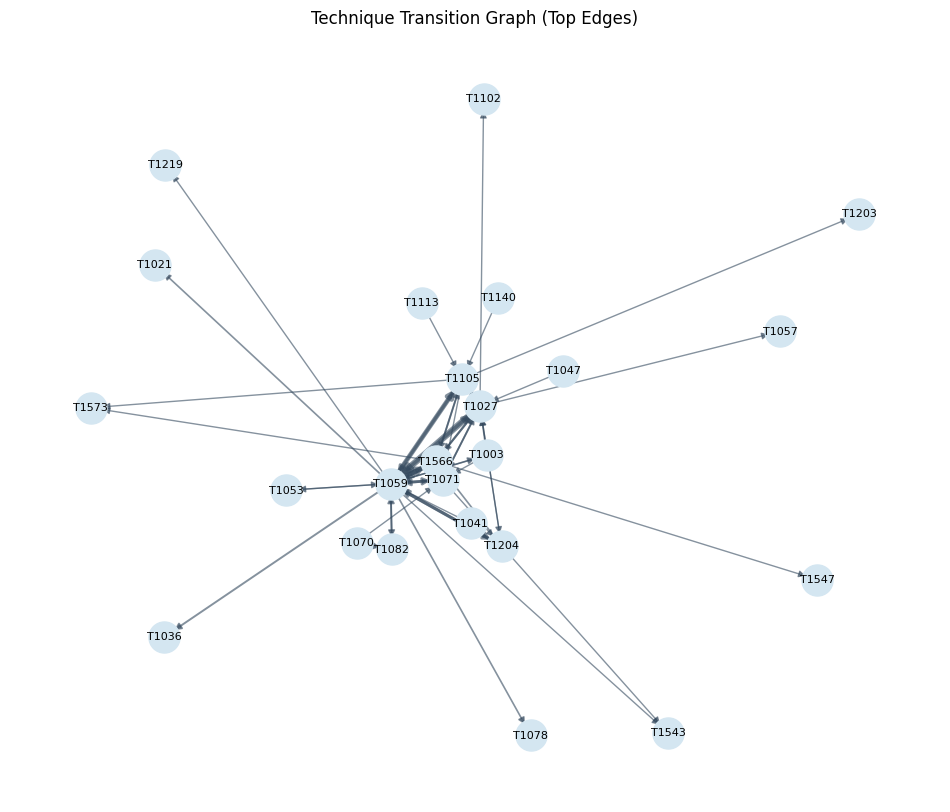

In [18]:
# Block 4b: NetworkX graph for visualization
import networkx as nx
import matplotlib.pyplot as plt

# Build a directed graph from the transition table.
G = nx.DiGraph()
for _, row in transition_df.iterrows():
    G.add_edge(row["source"], row["target"], weight=int(row["weight"]))

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

# Visualize a subgraph of the strongest transitions for readability.
top_n_edges = 50
edges_sorted = transition_df.head(top_n_edges)
G_top = nx.DiGraph()
for _, row in edges_sorted.iterrows():
    G_top.add_edge(row["source"], row["target"], weight=int(row["weight"]))

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_top, seed=42, k=0.6)
weights = [G_top[u][v]["weight"] for u, v in G_top.edges()]
widths = [max(1.0, w / 5.0) for w in weights]

nx.draw_networkx_nodes(G_top, pos, node_size=500, node_color="#d4e6f1")
nx.draw_networkx_edges(G_top, pos, arrows=True, width=widths, alpha=0.6, edge_color="#34495e")
nx.draw_networkx_labels(G_top, pos, font_size=8)

plt.title("Technique Transition Graph (Top Edges)")
plt.axis("off")
plt.show()

## Block 5: Convert graph into a lightweight Bayesian model
Treat each technique as a binary variable (present/absent). Use the transition graph to pick top-K incoming parents per technique, then estimate conditional probabilities from report-level co-occurrence with Laplace smoothing. This forms a simple belief model that can infer likely missing techniques from partial observations.


In [19]:
# Block 5: Convert graph into a lightweight Bayesian model
from collections import defaultdict

# Build report-level technique sets.
tech_series = (
    df[["report_id", "technique"]]
    .assign(
        technique=lambda d: d["technique"]
        .fillna("")
        .astype(str)
        .apply(lambda x: [t.strip() for t in x.split(",") if t.strip()])
    )
    .explode("technique")
)
tech_series = tech_series[tech_series["technique"].str.lower() != "nan"]

report_techs = (
    tech_series.groupby("report_id")["technique"].apply(lambda s: set(s))
)

# Parent selection from transition graph.
TOP_K_PARENTS = 3
incoming = transition_df.groupby("target").head(TOP_K_PARENTS)
parents_map = (
    incoming.groupby("target")["source"].apply(list).to_dict()
)

# Compute priors and conditional probabilities P(child=1 | all parents present).
alpha = 1.0
model = {}

for technique in sorted(set(tech_series["technique"])):
    parents = parents_map.get(technique, [])
    total_reports = len(report_techs)
    child_present = sum(technique in s for s in report_techs)
    prior = (child_present + alpha) / (total_reports + 2 * alpha)

    if parents:
        parents_present = sum(all(p in s for p in parents) for s in report_techs)
        child_and_parents = sum(
            (technique in s) and all(p in s for p in parents)
            for s in report_techs
        )
        cond = (child_and_parents + alpha) / (parents_present + 2 * alpha)
    else:
        cond = prior

    model[technique] = {
        "parents": parents,
        "prior": prior,
        "cond_all_parents": cond,
        "support_parents": parents_present if parents else 0,
    }

print(f"Techniques modeled: {len(model)}")


def infer_missing(observed: set[str], model_dict: dict, top_n: int = 10) -> list[tuple[str, float]]:
    scores = []
    for tech, info in model_dict.items():
        if tech in observed:
            continue
        parents = info["parents"]
        if parents and all(p in observed for p in parents):
            score = info["cond_all_parents"]
        else:
            score = info["prior"]
        scores.append((tech, score))
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:top_n]

# Example inference from a small observed set.
example_observed = set(list(report_techs.iloc[0])[:3])
print("Observed:", example_observed)
print("Top inferred:", infer_missing(example_observed, model, top_n=5))

Techniques modeled: 116
Observed: {'T1586', 'T1203', 'T1561'}
Top inferred: [('T1059', 0.5866666666666667), ('T1105', 0.5066666666666667), ('T1071', 0.49333333333333335), ('T1027', 0.48), ('T1082', 0.41333333333333333)]


## Block 6: Runtime demo loop (CAIRN-style, simplified)
Simulate incoming telemetry as text snippets, run the extractor to get technique probabilities, then feed those into the Bayesian model to infer missing techniques. The loop outputs top techniques, likely tactic stage, and a simple confidence score.


In [22]:
# Block 6: Runtime demo loop (CAIRN-style, simplified)
from collections import Counter

# Map techniques to their most common tactic for stage estimation.
technique_to_tactic = (
    df[["technique", "tactic"]]
    .assign(
        technique=lambda d: d["technique"].fillna("").astype(str),
        tactic=lambda d: d["tactic"].fillna("").astype(str),
    )
    .query("technique != '' and technique != 'nan'")
    .groupby("technique")["tactic"]
    .agg(lambda s: Counter(s).most_common(1)[0][0] if len(s) else "")
    .to_dict()
)

# Simulated telemetry snippets (replace with real logs later).
telemetry_snippets = [
    "User opened a suspicious PDF that triggered an exploit.",
    "PowerShell executed a base64-encoded command.",
    "Downloaded payload communicated with a remote server over HTTPS.",
]

# Extract technique probabilities from text.
tech_probs = baseline_clf.predict_proba(telemetry_snippets)
tech_probs = pd.DataFrame(tech_probs, columns=mlb.classes_)

# Treat techniques above a probability threshold as observed.
obs_threshold = 0.3
observed = set(tech_probs.columns[(tech_probs.max(axis=0) >= obs_threshold)])

# Infer missing techniques using the Bayesian model.
inferred = infer_missing(observed, model, top_n=10)

# Combine observed and inferred for a ranked view.
observed_scores = sorted(
    [(t, float(tech_probs[t].max())) for t in observed],
    key=lambda x: x[1],
    reverse=True,
)

combined = observed_scores + inferred

# Derive likely tactic stage from top techniques.
likely_tactics = [technique_to_tactic.get(t, "") for t, _ in combined[:10]]
likely_tactics = [t for t in likely_tactics if t]
likely_tactic = Counter(likely_tactics).most_common(1)[0][0] if likely_tactics else ""

# Simple confidence: mean of top-5 scores.
confidence = sum(score for _, score in combined[:5]) / max(1, len(combined[:5]))

print("Observed techniques (from text):", observed_scores[:5])
print("Top inferred techniques:", inferred[:5])
print("Likely tactic stage:", likely_tactic)
print(f"Confidence: {confidence:.2f}")

Observed techniques (from text): [('T1059', 0.3970886022242229), ('T1027', 0.3589190972858641)]
Top inferred techniques: [('T1105', 0.5066666666666667), ('T1071', 0.49333333333333335), ('T1082', 0.41333333333333333), ('T1003', 0.37333333333333335), ('T1036', 0.37333333333333335)]
Likely tactic stage: TA0002
Confidence: 0.43


## Block 7: Intervention suggestion (cheap heuristic)
Pick the technique with the highest uncertainty (posterior near 0.5) and map it to a recommended follow-up action from a static table. This gives a lightweight “what to check next” planner.


In [23]:
# Block 7: Intervention suggestion (cheap heuristic)
import math

# Static intervention table (extend as needed).
interventions = {
    "T1059": "Enable PowerShell Script Block Logging and review encoded commands.",
    "T1003": "Collect LSASS access telemetry and memory dump events.",
    "T1027": "Inspect for obfuscated files/scripts and decode payloads.",
    "T1105": "Monitor inbound tool transfers and suspicious downloads.",
    "T1041": "Review outbound data transfer volume and unusual destinations.",
    "T1071": "Inspect application-layer protocol usage and beaconing.",
}

# Compute per-technique uncertainty from posteriors.
# Use inferred scores plus observed scores as a proxy posterior list.
posterior = dict(combined)

uncertainty_scores = []
for tech, prob in posterior.items():
    # Uncertainty peaks near 0.5
    uncertainty = 1.0 - abs(prob - 0.5) * 2.0
    uncertainty_scores.append((tech, uncertainty, prob))

uncertainty_scores.sort(key=lambda x: x[1], reverse=True)

tech_choice, unc, prob = uncertainty_scores[0]
action = interventions.get(tech_choice, "Collect additional telemetry for this technique.")

print("Most uncertain technique:", tech_choice)
print(f"Posterior: {prob:.2f} | Uncertainty: {unc:.2f}")
print("Suggested action:", action)

Most uncertain technique: T1071
Posterior: 0.49 | Uncertainty: 0.99
Suggested action: Inspect application-layer protocol usage and beaconing.


In [25]:
# Block 7b: Expanded interventions + ATT&CK metadata (optional)
from pathlib import Path

# Expanded intervention table (examples).
interventions.update(
    {
        "T1059": "Enable PowerShell Script Block Logging and review encoded commands.",
        "T1055": "Check for process injection indicators and suspicious memory allocations.",
        "T1053": "Review scheduled task creation and anomalous task triggers.",
        "T1105": "Monitor inbound tool transfers and suspicious downloads.",
        "T1071": "Inspect application-layer protocol usage and beaconing.",
        "T1003": "Collect LSASS access telemetry and memory dump events.",
        "T1110": "Review authentication logs for brute-force and password spraying.",
        "T1566": "Check email gateways for phishing indicators and attachment opens.",
        "T1204": "Inspect user execution events and suspicious file opens.",
        "T1027": "Inspect for obfuscated files/scripts and decode payloads.",
        "T1041": "Review outbound data transfer volume and unusual destinations.",
    }
)


def load_attack_metadata() -> dict:
    # Optional local ATT&CK STIX file(s).
    candidates = [Path("enterprise-attack.json"), Path("cti") / "enterprise-attack.json"]
    stix_path = next((p for p in candidates if p.exists()), None)
    if not stix_path:
        return {}

    with stix_path.open("r", encoding="utf-8") as f:
        stix = json.load(f)

    meta = {}
    for obj in stix.get("objects", []):
        if obj.get("type") != "attack-pattern":
            continue
        ext_refs = obj.get("external_references", [])
        ext_id = None
        for ref in ext_refs:
            if ref.get("source_name") == "mitre-attack" and ref.get("external_id"):
                ext_id = ref.get("external_id")
                break
        if not ext_id:
            continue
        meta[ext_id] = {
            "name": obj.get("name", ""),
            "description": (obj.get("description", "") or "").strip(),
        }
    return meta


attack_meta = load_attack_metadata()

# If ATT&CK metadata is missing, fall back to tactic only.
if not attack_meta:
    attack_meta = {
        tech: {
            "name": "",
            "description": "",
            "tactic": technique_to_tactic.get(tech, ""),
        }
        for tech in posterior.keys()
    }

# Recompute the most uncertain technique and enrich the suggestion.
uncertainty_scores = []
for tech, prob in posterior.items():
    uncertainty = 1.0 - abs(prob - 0.5) * 2.0
    uncertainty_scores.append((tech, uncertainty, prob))

uncertainty_scores.sort(key=lambda x: x[1], reverse=True)
tech_choice, unc, prob = uncertainty_scores[0]
meta = attack_meta.get(tech_choice, {})

print("Most uncertain technique:", tech_choice)
if meta.get("name"):
    print("ATT&CK name:", meta.get("name"))
if meta.get("tactic"):
    print("Likely tactic:", meta.get("tactic"))
print(f"Posterior: {prob:.2f} | Uncertainty: {unc:.2f}")
print("Suggested action:", interventions.get(tech_choice, "Collect additional telemetry for this technique."))

Most uncertain technique: T1071
Likely tactic: TA0011
Posterior: 0.49 | Uncertainty: 0.99
Suggested action: Inspect application-layer protocol usage and beaconing.


### Block 7b: Expanded interventions + ATT&CK metadata (optional)
Extend the intervention table and enrich suggestions with ATT&CK technique names/descriptions when local STIX data is available.


### GenAI API keys (safe configuration)
Do not hardcode API keys in the notebook. Load them from environment variables so secrets are not committed to the repo.


In [ ]:
# GenAI API keys (safe configuration)
import os

# Expect keys to be set in the environment before running this cell.
# Example (PowerShell): setx OPENAI_API_KEY "<your-key>"
# Example (cmd): setx OPENAI_API_KEY "<your-key>"
# Example (bash): export OPENAI_API_KEY="<your-key>"

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY", "")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY", "")

if not (OPENAI_API_KEY or ANTHROPIC_API_KEY or GOOGLE_API_KEY):
    raise RuntimeError(
        "No GenAI API keys found in environment variables. Set one of: "
        "OPENAI_API_KEY, ANTHROPIC_API_KEY, GOOGLE_API_KEY."
    )

print("GenAI API key(s) detected via environment variables.")

GenAI API key(s) detected via environment variables.


In [28]:
# GenAI guidance (optional)
# Uses OpenAI if OPENAI_API_KEY is set; extend to other providers as needed.

def build_guidance_prompt(tech_id: str, meta: dict, action: str) -> str:
    name = meta.get("name", "")
    desc = meta.get("description", "")
    tactic = meta.get("tactic", "")
    return (
        "You are a cyber analyst assistant. Provide a short, actionable next-step "
        "recommendation based on the uncertain technique.\n\n"
        f"Technique ID: {tech_id}\n"
        f"Name: {name}\n"
        f"Tactic: {tactic}\n"
        f"Description: {desc}\n\n"
        f"Current suggested action: {action}\n\n"
        "Respond with 3-5 bullet points."
    )


def genai_guidance(tech_id: str, meta: dict, action: str) -> str:
    if not OPENAI_API_KEY:
        return "OPENAI_API_KEY not set; skipping GenAI guidance."

    try:
        from openai import OpenAI

        client = OpenAI(api_key=OPENAI_API_KEY)
        prompt = build_guidance_prompt(tech_id, meta, action)
        response = client.responses.create(
            model="gpt-4.1-mini",
            input=prompt,
        )
        return response.output_text.strip()
    except Exception as exc:
        return f"GenAI call failed: {exc}"


# Example: generate guidance for the most uncertain technique.
tech_choice, unc, prob = uncertainty_scores[0]
meta = attack_meta.get(tech_choice, {})
action = interventions.get(tech_choice, "Collect additional telemetry for this technique.")

print("Most uncertain technique:", tech_choice)
print(genai_guidance(tech_choice, meta, action))

Most uncertain technique: T1071
- Monitor network traffic for unusual or unauthorized application-layer protocol usage.  
- Analyze communication patterns for signs of beaconing or periodic data transfers.  
- Use deep packet inspection tools to identify potential covert channels within common protocols.  
- Establish baselines for normal protocol behavior to detect anomalies promptly.  
- Correlate findings with endpoint logs to identify potential compromised hosts.


### GenAI guidance (optional)
Use a GenAI model to generate a richer, human-readable next-step recommendation from the most uncertain technique and any available ATT&CK metadata.


In [ ]:
# GenAI .env support (optional)
# Requires: pip install python-dotenv
try:
    from dotenv import load_dotenv  # type: ignore

    load_dotenv()
    print("Loaded .env (if present)")
except Exception as exc:
    print("python-dotenv not installed or .env missing; skipping.")
    print("Install with: pip install python-dotenv")


### GenAI .env support (optional)
Load API keys from a local `.env` file (not committed) for convenience.
